In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn import model_selection
from keras import preprocessing, Input
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
import numpy as np
import os
import itertools
import numpy as np
import keras
import h5py
from keras import optimizers
from keras.models import load_model
from keras.layers import Bidirectional
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import plot_model
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns 
from sklearn.metrics import confusion_matrix 
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from keras.models import Model
from keras import preprocessing, Input
import os
import itertools
from PIL import Image, ImageFile

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
Training_path = '/content/drive/MyDrive/MultiOFF_Dataset/Split Dataset/Training_meme_dataset.csv'
Validation_path = '/content/drive/MyDrive/MultiOFF_Dataset/Split Dataset/Validation_meme_dataset.csv'
Testing_path = '/content/drive/MyDrive/MultiOFF_Dataset/Split Dataset/Testing_meme_dataset.csv'
img_dir = "/content/drive/MyDrive/MultiOFF_Dataset/Labelled Images"

#PreProcessing

In [4]:
STOPWORDS = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
EMAIL = re.compile('^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})$')

In [5]:
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = EMAIL.sub('', text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)    
    text = text.replace('x','')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

def encode_label(DataFrame, Label_col):
    t_y = DataFrame[Label_col].values
    Encoder = LabelEncoder()
    y = Encoder.fit_transform(t_y)
    DataFrame[Label_col] = y

def preprocess_text(Training_path,Validation_path, Testing_path):
    # function to preprocess input
    training_DF = pd.read_csv(Training_path, sep = ',')
    validation_DF = pd.read_csv(Validation_path, sep = ',')
    testing_DF = pd.read_csv(Testing_path, sep = ',')

    # encoding all the labels 
    encode_label(testing_DF,'label')
    encode_label(training_DF, 'label')
    encode_label(validation_DF, 'label')

    clean_text(training_DF['sentence'][0])

    # Processing the text
    training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
    testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
    validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

    return training_DF, testing_DF, validation_DF

In [6]:
# Dividing data in test, train, validation
training_DF, testing_DF, validation_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [7]:
training_DF.head()

,image_name,sentence,label
0,LJ3r8Gy.jpg.png,official bernie sanders drinking game every ti...,0
1,qDnIIHA.png,228 pm wall inside nazi gas chamber dwebs demo...,1
2,1JQk5NF.png,shit waddup bernie sanders com,1
3,iMMNq.png,mitt romney worst republican country putup bar...,0
4,jAi3iI1.png,anonymous id duqda1io 08 05 16 fri 163248 8423...,0


#Code

In [8]:
def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '/' + name for name in DF[Col_name]]
    return img_path

In [9]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

In [10]:
maxlen=100
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen,padding='post')
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen,padding='post')
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen,padding='post')

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [11]:
def get_input(path):
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img = image.load_img(path, target_size=(224,224))    
    return(img)

def get_output(path,label_file=None):
    # Spliting the path and take out the image id    
    filename = path[56:]
    # Taking list of labels
    labels = list(label_file[label_file['image_name'] == filename]['label'].values)
    # for duplicate selecting labels
    if len(labels) <= 2:
        label = labels[0]
    elif len(labels) > 2:
        uni_label = list(set(labels))
        count_label = [labels.count(lab) for lab in uni_label]
        lab_idx = count_label.index(max(count_label))
        label = uni_label[lab_idx]
    return label

def process_input(img):   
    img_data = image.img_to_array(img)   
    img_data = preprocess_input(img_data)
    img_data = np.expand_dims(img_data, axis=0)
    return(img_data)

In [12]:
def image_generator(files,label_file, batch_size = None):   
    idxs = list(range(len(files)))
    idx = 0
    while True: 
        batch_paths = files[idx:idx+batch_size]
        idx = idx + batch_size
        batch_input = [] # Batch input initialization
        batch_output = [] # Batch output initialization
          
        # Read in each input, perform preprocessing and get labels    
        for input_path in batch_paths:
            input = get_input(input_path ) # Load image
            output = get_output(input_path,label_file=label_file ) # Load label of the image
            input = process_input(img=input) # Process the image
            batch_input.append(input[0]) # Append the image
            batch_output.append(output)  # Append the label
            
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        if len(batch_x) < batch_size:
            idx = 0
        else:             
            yield (batch_x, batch_y)

In [13]:
# Creating train, test, val, generator for image
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_DF, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_DF, batch_size=1)

In [14]:
# Assigning class weights
class_weight = {1: 1.4,
                0: 1.}

In [15]:
# Defining model with Adam optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
TotalTrainingSamples = len(training_DF)
TrainingBatchSize = 32
TotalvalidationSamples = len(validation_DF)
ValidationBatchSize = 1
validation_steps = TotalvalidationSamples // ValidationBatchSize
steps_per_epoch = TotalTrainingSamples // TrainingBatchSize

#PreTrained Models

In [19]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation
batch_size = 32

In [20]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [21]:
print(type(model_dictionary))

<class 'dict'>


In [22]:
for i in model_dictionary:
  print(i,end=" ")
  print(model_dictionary[i])

DenseNet121 <function DenseNet121 at 0x7fe2fcc7f710>
DenseNet169 <function DenseNet169 at 0x7fe2fcc7f7a0>
DenseNet201 <function DenseNet201 at 0x7fe2fcc7f830>
EfficientNetB0 <function EfficientNetB0 at 0x7fe2fcc86560>
EfficientNetB1 <function EfficientNetB1 at 0x7fe2fcc865f0>
EfficientNetB2 <function EfficientNetB2 at 0x7fe2fcc86680>
EfficientNetB3 <function EfficientNetB3 at 0x7fe2fcc86710>
EfficientNetB4 <function EfficientNetB4 at 0x7fe2fcc867a0>
EfficientNetB5 <function EfficientNetB5 at 0x7fe2fcc86830>
EfficientNetB6 <function EfficientNetB6 at 0x7fe2fcc868c0>
EfficientNetB7 <function EfficientNetB7 at 0x7fe2fcc86950>
InceptionResNetV2 <function InceptionResNetV2 at 0x7fe2fcc86440>
InceptionV3 <function InceptionV3 at 0x7fe2fcc8e050>
MobileNet <function MobileNet at 0x7fe2fcc8e9e0>
MobileNetV2 <function MobileNetV2 at 0x7fe2fcc8eef0>
MobileNetV3Large <function MobileNetV3Large at 0x7fe2fcc9c4d0>
MobileNetV3Small <function MobileNetV3Small at 0x7fe2fcc9c440>
NASNetLarge <function N

In [23]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [24]:
for model_name, model in tqdm(model_dictionary.items()):
  if 'NASNetLarge' in model_name:
    print("not applicable")
  else:
    print(model_name)

100%|██████████| 28/28 [00:00<00:00, 3253.65it/s]

DenseNet121
DenseNet169
DenseNet201
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5
EfficientNetB6
EfficientNetB7
InceptionResNetV2
InceptionV3
MobileNet
MobileNetV2
MobileNetV3Large
MobileNetV3Small
not applicable
NASNetMobile
ResNet101
ResNet101V2
ResNet152
ResNet152V2
ResNet50
ResNet50V2
VGG16
VGG19
Xception


#Training

In [25]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
      continue
    else:
        input_shape=(224,224,3)
  
    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(weights='imagenet', include_top=False)
    for layer in pre_trained_model.layers:
      layer.trainable=False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.GlobalAveragePooling2D())
    clf_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    clf_model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    try:
      history = clf_model.fit(img_gen_train, epochs=10, validation_data=img_gen_val,validation_steps = validation_steps,steps_per_epoch=steps_per_epoch,shuffle=False,class_weight=class_weight)
    # Calculate all relevant metrics
      model_benchmarks['model_name'].append(model_name)
      model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
      model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
    except:
      continue

  0%|          | 0/28 [00:00<?, ?it/s]

29089792/29084464 [==============================] - 0s 0us/step
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
13/13 [==============================] - 161s 10s/step - loss: 3.2404 - accuracy: 0.5120 - val_loss: 2.4457 - val_accuracy: 0.5235
Epoch 2/10
13/13 [==============================] - 12s 998ms/step - loss: 2.4665 - accuracy: 0.5168 - val_loss: 2.2105 - val_accuracy: 0.5168
Epoch 3/10
13/13 [==============================] - 13s 1s/step - loss: 2.2463 - accuracy: 0.5096 - val_loss: 2.0735 - val_accuracy: 0.4966
Epoch 4/10
13/13 [==============================] - 13s 1s/step - loss: 2.0751 - accuracy: 0.5264 - val_loss: 2.0330 - val_accuracy: 0.5168
Epoch 5/10
13/13 [==============================] - 12s 963ms/step - loss: 1.9376 - accuracy: 0.5385 - val_loss: 2.0132 - val_accuracy: 0.5101
Epoch 6/10
13/13 [==============================] - 12s 957ms/step - loss: 1.8230 - accur

  4%|▎         | 1/28 [05:45<2:35:25, 345.38s/it]

51879936/51877672 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 23s 1s/step - loss: 4.1707 - accuracy: 0.4784 - val_loss: 1.8436 - val_accuracy: 0.6242
Epoch 2/10
13/13 [==============================] - 13s 1s/step - loss: 2.9287 - accuracy: 0.4880 - val_loss: 1.8120 - val_accuracy: 0.6040
Epoch 3/10
13/13 [==============================] - 13s 1s/step - loss: 2.5439 - accuracy: 0.5240 - val_loss: 1.7963 - val_accuracy: 0.5705
Epoch 4/10
13/13 [==============================] - 13s 1s/step - loss: 2.3569 - accuracy: 0.5385 - val_loss: 1.6190 - val_accuracy: 0.6107
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 1.8514 - accuracy: 0.5673 - val_loss: 1.6671 - val_accuracy: 0.5906
Epoch 6/10
13/13 [==============================] - 14s 1s/step - loss: 2.2316 - accuracy: 0.5312 - val_loss: 1.4954 - val_accuracy: 0.5705
Epoch 7/10
13/13 [==============================] - 13s 1s/step - loss: 2.1852 - accuracy: 0.55

  7%|▋         | 2/28 [08:19<2:04:48, 288.03s/it]

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 27s 1s/step - loss: 3.5765 - accuracy: 0.4928 - val_loss: 1.8352 - val_accuracy: 0.6242
Epoch 2/10
13/13 [==============================] - 13s 1s/step - loss: 2.2741 - accuracy: 0.5168 - val_loss: 2.5568 - val_accuracy: 0.6040
Epoch 3/10
13/13 [==============================] - 14s 1s/step - loss: 2.1963 - accuracy: 0.5481 - val_loss: 2.0884 - val_accuracy: 0.6242
Epoch 4/10
13/13 [==============================] - 14s 1s/step - loss: 2.4082 - accuracy: 0.5481 - val_loss: 1.5873 - val_accuracy: 0.6107
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 1.7715 - accuracy: 0.5601 - val_loss: 2.3632 - val_accuracy: 0.6107
Epoch 6/10
13/13 [==============================] - 13s 1s/step - loss: 1.8016 - accuracy: 0.5841 - val_loss: 1.5626 - val_accuracy: 0.6376
Epoch 7/10
13/13 [==============================] - 13s 1s/step - loss: 2.2381 - accuracy: 0.56

 11%|█         | 3/28 [10:56<1:43:39, 248.76s/it]

16711680/16705208 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 18s 1s/step - loss: 0.8393 - accuracy: 0.4736 - val_loss: 0.6830 - val_accuracy: 0.5705
Epoch 2/10
13/13 [==============================] - 12s 977ms/step - loss: 0.7880 - accuracy: 0.5841 - val_loss: 0.6783 - val_accuracy: 0.5839
Epoch 3/10
13/13 [==============================] - 12s 995ms/step - loss: 0.7659 - accuracy: 0.5938 - val_loss: 0.6718 - val_accuracy: 0.6174
Epoch 4/10
13/13 [==============================] - 12s 953ms/step - loss: 0.7467 - accuracy: 0.6418 - val_loss: 0.6697 - val_accuracy: 0.6242
Epoch 5/10
13/13 [==============================] - 11s 925ms/step - loss: 0.7287 - accuracy: 0.6587 - val_loss: 0.6681 - val_accuracy: 0.6242
Epoch 6/10
13/13 [==============================] - 11s 925ms/step - loss: 0.7204 - accuracy: 0.6683 - val_loss: 0.6705 - val_accuracy: 0.6309
Epoch 7/10
13/13 [==============================] - 11s 922ms/step - loss: 0.704

 14%|█▍        | 4/28 [13:26<1:27:38, 219.08s/it]

27025408/27018416 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 22s 1s/step - loss: 0.8367 - accuracy: 0.5096 - val_loss: 0.6876 - val_accuracy: 0.5705
Epoch 2/10
13/13 [==============================] - 12s 955ms/step - loss: 0.7928 - accuracy: 0.5553 - val_loss: 0.6878 - val_accuracy: 0.5839
Epoch 3/10
13/13 [==============================] - 12s 1s/step - loss: 0.7799 - accuracy: 0.5817 - val_loss: 0.6868 - val_accuracy: 0.5772
Epoch 4/10
13/13 [==============================] - 12s 1s/step - loss: 0.7563 - accuracy: 0.6418 - val_loss: 0.6854 - val_accuracy: 0.5705
Epoch 5/10
13/13 [==============================] - 12s 971ms/step - loss: 0.7363 - accuracy: 0.6659 - val_loss: 0.6820 - val_accuracy: 0.5638
Epoch 6/10
13/13 [==============================] - 12s 959ms/step - loss: 0.7162 - accuracy: 0.6803 - val_loss: 0.6830 - val_accuracy: 0.5705
Epoch 7/10
13/13 [==============================] - 12s 961ms/step - loss: 0.7108 - ac

 18%|█▊        | 5/28 [15:40<1:14:09, 193.46s/it]

31793152/31790344 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 22s 1s/step - loss: 0.8198 - accuracy: 0.5288 - val_loss: 0.7127 - val_accuracy: 0.4832
Epoch 2/10
13/13 [==============================] - 12s 985ms/step - loss: 0.7811 - accuracy: 0.5913 - val_loss: 0.7077 - val_accuracy: 0.5168
Epoch 3/10
13/13 [==============================] - 13s 1s/step - loss: 0.7656 - accuracy: 0.6250 - val_loss: 0.7013 - val_accuracy: 0.5369
Epoch 4/10
13/13 [==============================] - 13s 1s/step - loss: 0.7415 - accuracy: 0.6490 - val_loss: 0.7039 - val_accuracy: 0.5235
Epoch 5/10
13/13 [==============================] - 12s 988ms/step - loss: 0.7254 - accuracy: 0.6803 - val_loss: 0.7005 - val_accuracy: 0.5235
Epoch 6/10
13/13 [==============================] - 12s 980ms/step - loss: 0.7133 - accuracy: 0.6995 - val_loss: 0.7048 - val_accuracy: 0.5369
Epoch 7/10
13/13 [==============================] - 12s 981ms/step - loss: 0.7002 - ac

 21%|██▏       | 6/28 [17:56<1:04:35, 176.18s/it]

43941888/43941136 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 25s 1s/step - loss: 0.8333 - accuracy: 0.5024 - val_loss: 0.6898 - val_accuracy: 0.5503
Epoch 2/10
13/13 [==============================] - 12s 1000ms/step - loss: 0.7786 - accuracy: 0.5745 - val_loss: 0.6854 - val_accuracy: 0.5570
Epoch 3/10
13/13 [==============================] - 12s 999ms/step - loss: 0.7500 - accuracy: 0.6418 - val_loss: 0.6800 - val_accuracy: 0.5772
Epoch 4/10
13/13 [==============================] - 12s 1s/step - loss: 0.7286 - accuracy: 0.6587 - val_loss: 0.6806 - val_accuracy: 0.5638
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 0.7153 - accuracy: 0.6707 - val_loss: 0.6792 - val_accuracy: 0.5570
Epoch 6/10
13/13 [==============================] - 13s 1s/step - loss: 0.6927 - accuracy: 0.7212 - val_loss: 0.6746 - val_accuracy: 0.5705
Epoch 7/10
13/13 [==============================] - 12s 1s/step - loss: 0.6682 - accurac

 25%|██▌       | 7/28 [20:30<59:23, 169.68s/it]  

71688192/71686520 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 26s 1s/step - loss: 0.8188 - accuracy: 0.5096 - val_loss: 0.6766 - val_accuracy: 0.6107
Epoch 2/10
13/13 [==============================] - 12s 1s/step - loss: 0.7719 - accuracy: 0.6130 - val_loss: 0.6717 - val_accuracy: 0.6174
Epoch 3/10
13/13 [==============================] - 13s 1s/step - loss: 0.7533 - accuracy: 0.6635 - val_loss: 0.6679 - val_accuracy: 0.6040
Epoch 4/10
13/13 [==============================] - 13s 1s/step - loss: 0.7269 - accuracy: 0.6971 - val_loss: 0.6674 - val_accuracy: 0.5839
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 0.7136 - accuracy: 0.6923 - val_loss: 0.6681 - val_accuracy: 0.5772
Epoch 6/10
13/13 [==============================] - 13s 1s/step - loss: 0.7029 - accuracy: 0.7236 - val_loss: 0.6654 - val_accuracy: 0.5839
Epoch 7/10
13/13 [==============================] - 13s 1s/step - loss: 0.6828 - accuracy: 0.72

 29%|██▊       | 8/28 [23:07<55:16, 165.83s/it]

115269632/115263384 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 30s 2s/step - loss: 0.8256 - accuracy: 0.5024 - val_loss: 0.6747 - val_accuracy: 0.5906
Epoch 2/10
13/13 [==============================] - 14s 1s/step - loss: 0.7849 - accuracy: 0.5769 - val_loss: 0.6700 - val_accuracy: 0.5906
Epoch 3/10
13/13 [==============================] - 15s 1s/step - loss: 0.7546 - accuracy: 0.6490 - val_loss: 0.6699 - val_accuracy: 0.6040
Epoch 4/10
13/13 [==============================] - 15s 1s/step - loss: 0.7440 - accuracy: 0.6514 - val_loss: 0.6711 - val_accuracy: 0.6040
Epoch 5/10
13/13 [==============================] - 14s 1s/step - loss: 0.7195 - accuracy: 0.6899 - val_loss: 0.6709 - val_accuracy: 0.6107
Epoch 6/10
13/13 [==============================] - 13s 1s/step - loss: 0.7041 - accuracy: 0.7260 - val_loss: 0.6703 - val_accuracy: 0.5772
Epoch 7/10
13/13 [==============================] - 14s 1s/step - loss: 0.6946 - accuracy: 0.

 32%|███▏      | 9/28 [26:47<57:37, 181.97s/it]

165240832/165234480 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 33s 2s/step - loss: 0.8145 - accuracy: 0.5000 - val_loss: 0.7080 - val_accuracy: 0.4832
Epoch 2/10
13/13 [==============================] - 15s 1s/step - loss: 0.7818 - accuracy: 0.5865 - val_loss: 0.7002 - val_accuracy: 0.5235
Epoch 3/10
13/13 [==============================] - 14s 1s/step - loss: 0.7545 - accuracy: 0.6514 - val_loss: 0.6995 - val_accuracy: 0.5302
Epoch 4/10
13/13 [==============================] - 14s 1s/step - loss: 0.7383 - accuracy: 0.6971 - val_loss: 0.6984 - val_accuracy: 0.4966
Epoch 5/10
13/13 [==============================] - 14s 1s/step - loss: 0.7223 - accuracy: 0.7236 - val_loss: 0.6914 - val_accuracy: 0.5436
Epoch 6/10
13/13 [==============================] - 15s 1s/step - loss: 0.7078 - accuracy: 0.7500 - val_loss: 0.6950 - val_accuracy: 0.5302
Epoch 7/10
13/13 [==============================] - 15s 1s/step - loss: 0.7009 - accuracy: 0.

 36%|███▌      | 10/28 [29:38<53:38, 178.81s/it]

258080768/258076736 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 40s 2s/step - loss: 0.8320 - accuracy: 0.5120 - val_loss: 0.6757 - val_accuracy: 0.5638
Epoch 2/10
13/13 [==============================] - 16s 1s/step - loss: 0.7772 - accuracy: 0.6034 - val_loss: 0.6702 - val_accuracy: 0.5638
Epoch 3/10
13/13 [==============================] - 16s 1s/step - loss: 0.7595 - accuracy: 0.6154 - val_loss: 0.6664 - val_accuracy: 0.5638
Epoch 4/10
13/13 [==============================] - 16s 1s/step - loss: 0.7401 - accuracy: 0.6683 - val_loss: 0.6648 - val_accuracy: 0.5906
Epoch 5/10
13/13 [==============================] - 17s 1s/step - loss: 0.7210 - accuracy: 0.6755 - val_loss: 0.6620 - val_accuracy: 0.5839
Epoch 6/10
13/13 [==============================] - 16s 1s/step - loss: 0.7003 - accuracy: 0.7212 - val_loss: 0.6639 - val_accuracy: 0.6040
Epoch 7/10
13/13 [==============================] - 16s 1s/step - loss: 0.6817 - accuracy: 0.

 39%|███▉      | 11/28 [33:25<54:45, 193.29s/it]

219062272/219055592 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 29s 2s/step - loss: 68.8764 - accuracy: 0.5024 - val_loss: 39.9201 - val_accuracy: 0.6107
Epoch 2/10
13/13 [==============================] - 15s 1s/step - loss: 47.7463 - accuracy: 0.5024 - val_loss: 29.8249 - val_accuracy: 0.3893
Epoch 3/10
13/13 [==============================] - 14s 1s/step - loss: 40.2525 - accuracy: 0.5024 - val_loss: 37.9370 - val_accuracy: 0.6107
Epoch 4/10
13/13 [==============================] - 14s 1s/step - loss: 44.5652 - accuracy: 0.5024 - val_loss: 24.6132 - val_accuracy: 0.3893
Epoch 5/10
13/13 [==============================] - 14s 1s/step - loss: 37.3831 - accuracy: 0.5096 - val_loss: 39.7730 - val_accuracy: 0.6107
Epoch 6/10
13/13 [==============================] - 14s 1s/step - loss: 44.8168 - accuracy: 0.5024 - val_loss: 22.4365 - val_accuracy: 0.3893
Epoch 7/10
13/13 [==============================] - 15s 1s/step - loss: 31.4576 -

 43%|████▎     | 12/28 [37:05<53:39, 201.21s/it]

87916544/87910968 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 20s 1s/step - loss: 5.3370 - accuracy: 0.5192 - val_loss: 3.7090 - val_accuracy: 0.4430
Epoch 2/10
13/13 [==============================] - 12s 1s/step - loss: 3.1711 - accuracy: 0.5361 - val_loss: 3.3255 - val_accuracy: 0.5570
Epoch 3/10
13/13 [==============================] - 12s 966ms/step - loss: 3.0802 - accuracy: 0.5577 - val_loss: 3.1162 - val_accuracy: 0.5436
Epoch 4/10
13/13 [==============================] - 12s 971ms/step - loss: 2.3844 - accuracy: 0.5793 - val_loss: 4.1900 - val_accuracy: 0.3893
Epoch 5/10
13/13 [==============================] - 12s 958ms/step - loss: 2.9082 - accuracy: 0.5986 - val_loss: 2.8695 - val_accuracy: 0.5570
Epoch 6/10
13/13 [==============================] - 12s 1s/step - loss: 2.2750 - accuracy: 0.5938 - val_loss: 4.3222 - val_accuracy: 0.3758
Epoch 7/10
13/13 [==============================] - 12s 1s/step - loss: 2.3626 - accur

 46%|████▋     | 13/28 [39:15<45:00, 180.02s/it]

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 14s 1s/step - loss: 0.9378 - accuracy: 0.5216 - val_loss: 0.7890 - val_accuracy: 0.4631
Epoch 2/10
13/13 [==============================] - 11s 940ms/step - loss: 0.8383 - accuracy: 0.5625 - val_loss: 0.7824 - val_accuracy: 0.4698
Epoch 3/10
13/13 [==============================] - 11s 930ms/step - loss: 0.7958 - accuracy: 0.5865 - val_loss: 0.7810 - val_accuracy: 0.4631
Epoch 4/10
13/13 [==============================] - 11s 911ms/step - loss: 0.7614 - accuracy: 0.6178 - val_loss: 0.7816 - val_accuracy: 0.4832
Epoch 5/10
13/13 [==============================] - 11s 927ms/step - loss: 0.7322 - accuracy: 0.6274 - val_loss: 0.7832 - val_accuracy: 0.4698
Epoch 6/10
13/13 [==============================] - 11s 917ms/step - loss: 0.7069 - accuracy: 0.6611 - val_loss: 0.7852 - val_accuracy: 0.4899
Epoch 7/10
13/13 [==============================] - 10s 864ms/step - loss: 0.684

 50%|█████     | 14/28 [41:09<37:22, 160.21s/it]

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 16s 1s/step - loss: 0.9523 - accuracy: 0.4760 - val_loss: 0.7380 - val_accuracy: 0.4966
Epoch 2/10
13/13 [==============================] - 11s 908ms/step - loss: 0.8317 - accuracy: 0.5264 - val_loss: 0.7236 - val_accuracy: 0.5503
Epoch 3/10
13/13 [==============================] - 11s 898ms/step - loss: 0.7867 - accuracy: 0.5913 - val_loss: 0.7156 - val_accuracy: 0.5436
Epoch 4/10
13/13 [==============================] - 11s 902ms/step - loss: 0.7501 - accuracy: 0.6274 - val_loss: 0.7112 - val_accuracy: 0.5503
Epoch 5/10
13/13 [==============================] - 11s 894ms/step - loss: 0.7193 - accuracy: 0.6587 - val_loss: 0.7091 - val_accuracy: 0.5570
Epoch 6/10
13/13 [==============================] - 12s 958ms/step - loss: 0.6927 - accuracy: 0.6827 - val_loss: 0.7085 - val_accuracy: 0.5570
Epoch 7/10
13/13 [==============================] - 12s 962ms/step - loss: 0.6692 

 54%|█████▎    | 15/28 [43:06<31:54, 147.26s/it]

17612800/17605208 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 17s 1s/step - loss: 0.8639 - accuracy: 0.5409 - val_loss: 0.7237 - val_accuracy: 0.5839
Epoch 2/10
13/13 [==============================] - 12s 965ms/step - loss: 0.8021 - accuracy: 0.5697 - val_loss: 0.7208 - val_accuracy: 0.5973
Epoch 3/10
13/13 [==============================] - 11s 922ms/step - loss: 0.7721 - accuracy: 0.6058 - val_loss: 0.7209 - val_accuracy: 0.5772
Epoch 4/10
13/13 [==============================] - 11s 897ms/step - loss: 0.7483 - accuracy: 0.6202 - val_loss: 0.7214 - val_accuracy: 0.5839
Epoch 5/10
13/13 [==============================] - 11s 900ms/step - loss: 0.7276 - accuracy: 0.6466 - val_loss: 0.7227 - val_accuracy: 0.5772
Epoch 6/10
13/13 [==============================] - 11s 897ms/step - loss: 0.7090 - accuracy: 0.6779 - val_loss: 0.7248 - val_accuracy: 0.5839
Epoch 7/10
13/13 [==============================] - 12s 961ms/step - loss: 0.691

 57%|█████▋    | 16/28 [45:34<29:27, 147.28s/it]

6701056/6698480 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 17s 1s/step - loss: 0.8911 - accuracy: 0.5192 - val_loss: 0.7368 - val_accuracy: 0.4430
Epoch 2/10
13/13 [==============================] - 11s 911ms/step - loss: 0.8368 - accuracy: 0.5288 - val_loss: 0.7139 - val_accuracy: 0.4899
Epoch 3/10
13/13 [==============================] - 12s 959ms/step - loss: 0.8153 - accuracy: 0.5673 - val_loss: 0.7006 - val_accuracy: 0.5034
Epoch 4/10
13/13 [==============================] - 11s 956ms/step - loss: 0.7981 - accuracy: 0.5793 - val_loss: 0.6919 - val_accuracy: 0.5168
Epoch 5/10
13/13 [==============================] - 11s 891ms/step - loss: 0.7831 - accuracy: 0.5793 - val_loss: 0.6859 - val_accuracy: 0.5369
Epoch 6/10
13/13 [==============================] - 11s 891ms/step - loss: 0.7697 - accuracy: 0.6010 - val_loss: 0.6816 - val_accuracy: 0.5638
Epoch 7/10
13/13 [==============================] - 11s 882ms/step - loss: 0.7573 

 61%|██████    | 17/28 [47:33<25:28, 138.95s/it]

19996672/19993432 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 29s 1s/step - loss: 1.2430 - accuracy: 0.4856 - val_loss: 1.1816 - val_accuracy: 0.4765
Epoch 2/10
13/13 [==============================] - 13s 1s/step - loss: 1.0675 - accuracy: 0.5192 - val_loss: 1.1251 - val_accuracy: 0.4631
Epoch 3/10
13/13 [==============================] - 14s 1s/step - loss: 0.9807 - accuracy: 0.5409 - val_loss: 1.0859 - val_accuracy: 0.4765
Epoch 4/10
13/13 [==============================] - 13s 1s/step - loss: 0.9204 - accuracy: 0.5529 - val_loss: 1.0463 - val_accuracy: 0.4631
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 0.8736 - accuracy: 0.5865 - val_loss: 1.0092 - val_accuracy: 0.4631
Epoch 6/10
13/13 [==============================] - 12s 1s/step - loss: 0.8381 - accuracy: 0.5986 - val_loss: 0.9794 - val_accuracy: 0.4698
Epoch 7/10
13/13 [==============================] - 13s 1s/step - loss: 0.8118 - accuracy: 0.60

 68%|██████▊   | 19/28 [50:13<18:10, 121.16s/it]

171450368/171446536 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 22s 1s/step - loss: 0.9590 - accuracy: 0.4832 - val_loss: 0.7098 - val_accuracy: 0.5436
Epoch 2/10
13/13 [==============================] - 14s 1s/step - loss: 0.8181 - accuracy: 0.5625 - val_loss: 0.7128 - val_accuracy: 0.5503
Epoch 3/10
13/13 [==============================] - 13s 1s/step - loss: 0.7541 - accuracy: 0.6130 - val_loss: 0.7148 - val_accuracy: 0.5436
Epoch 4/10
13/13 [==============================] - 14s 1s/step - loss: 0.7058 - accuracy: 0.6611 - val_loss: 0.7176 - val_accuracy: 0.5705
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 0.6649 - accuracy: 0.7019 - val_loss: 0.7215 - val_accuracy: 0.5772
Epoch 6/10
13/13 [==============================] - 13s 1s/step - loss: 0.6288 - accuracy: 0.7356 - val_loss: 0.7262 - val_accuracy: 0.5839
Epoch 7/10
13/13 [==============================] - 13s 1s/step - loss: 0.5964 - accuracy: 0.

 71%|███████▏  | 20/28 [52:37<17:06, 128.26s/it]

171319296/171317808 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 20s 1s/step - loss: 66.3736 - accuracy: 0.5216 - val_loss: 43.3871 - val_accuracy: 0.5302
Epoch 2/10
13/13 [==============================] - 13s 1s/step - loss: 49.2242 - accuracy: 0.4904 - val_loss: 38.7971 - val_accuracy: 0.5302
Epoch 3/10
13/13 [==============================] - 13s 1s/step - loss: 44.0077 - accuracy: 0.4904 - val_loss: 36.1725 - val_accuracy: 0.5503
Epoch 4/10
13/13 [==============================] - 13s 1s/step - loss: 45.7754 - accuracy: 0.4928 - val_loss: 33.7186 - val_accuracy: 0.5369
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 41.2919 - accuracy: 0.5096 - val_loss: 37.1361 - val_accuracy: 0.5503
Epoch 6/10
13/13 [==============================] - 13s 1s/step - loss: 40.0671 - accuracy: 0.5168 - val_loss: 38.1149 - val_accuracy: 0.5839
Epoch 7/10
13/13 [==============================] - 13s 1s/step - loss: 41.7127 -

 75%|███████▌  | 21/28 [55:09<15:46, 135.22s/it]

234700800/234698864 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 26s 2s/step - loss: 0.9767 - accuracy: 0.5072 - val_loss: 0.7465 - val_accuracy: 0.5034
Epoch 2/10
13/13 [==============================] - 15s 1s/step - loss: 0.8211 - accuracy: 0.5649 - val_loss: 0.7401 - val_accuracy: 0.5235
Epoch 3/10
13/13 [==============================] - 15s 1s/step - loss: 0.7549 - accuracy: 0.6322 - val_loss: 0.7452 - val_accuracy: 0.5101
Epoch 4/10
13/13 [==============================] - 14s 1s/step - loss: 0.7021 - accuracy: 0.6755 - val_loss: 0.7549 - val_accuracy: 0.5101
Epoch 5/10
13/13 [==============================] - 14s 1s/step - loss: 0.6573 - accuracy: 0.7019 - val_loss: 0.7665 - val_accuracy: 0.5235
Epoch 6/10
13/13 [==============================] - 14s 1s/step - loss: 0.6181 - accuracy: 0.7476 - val_loss: 0.7787 - val_accuracy: 0.5168
Epoch 7/10
13/13 [==============================] - 14s 1s/step - loss: 0.5834 - accuracy: 0.

 79%|███████▊  | 22/28 [58:46<15:58, 159.81s/it]

234553344/234545216 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 24s 1s/step - loss: 148.3700 - accuracy: 0.5072 - val_loss: 85.3215 - val_accuracy: 0.6107
Epoch 2/10
13/13 [==============================] - 15s 1s/step - loss: 92.3586 - accuracy: 0.5072 - val_loss: 101.5822 - val_accuracy: 0.3893
Epoch 3/10
13/13 [==============================] - 14s 1s/step - loss: 92.1895 - accuracy: 0.4952 - val_loss: 66.3853 - val_accuracy: 0.6107
Epoch 4/10
13/13 [==============================] - 14s 1s/step - loss: 81.8197 - accuracy: 0.5264 - val_loss: 35.1626 - val_accuracy: 0.3960
Epoch 5/10
13/13 [==============================] - 14s 1s/step - loss: 89.2540 - accuracy: 0.5120 - val_loss: 70.0782 - val_accuracy: 0.6107
Epoch 6/10
13/13 [==============================] - 14s 1s/step - loss: 83.8374 - accuracy: 0.5168 - val_loss: 40.2167 - val_accuracy: 0.3758
Epoch 7/10
13/13 [==============================] - 15s 1s/step - loss: 88.7894

 82%|████████▏ | 23/28 [1:01:25<13:17, 159.43s/it]

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 17s 1s/step - loss: 0.9095 - accuracy: 0.5433 - val_loss: 0.7947 - val_accuracy: 0.4497
Epoch 2/10
13/13 [==============================] - 12s 986ms/step - loss: 0.7768 - accuracy: 0.6082 - val_loss: 0.7901 - val_accuracy: 0.4631
Epoch 3/10
13/13 [==============================] - 12s 1s/step - loss: 0.7179 - accuracy: 0.6611 - val_loss: 0.7918 - val_accuracy: 0.4765
Epoch 4/10
13/13 [==============================] - 12s 1s/step - loss: 0.6738 - accuracy: 0.7115 - val_loss: 0.7973 - val_accuracy: 0.4631
Epoch 5/10
13/13 [==============================] - 12s 956ms/step - loss: 0.6369 - accuracy: 0.7524 - val_loss: 0.8034 - val_accuracy: 0.4631
Epoch 6/10
13/13 [==============================] - 11s 947ms/step - loss: 0.6046 - accuracy: 0.7692 - val_loss: 0.8083 - val_accuracy: 0.4899
Epoch 7/10
13/13 [==============================] - 11s 943ms/step - loss: 0.5756 - ac

 86%|████████▌ | 24/28 [1:03:33<10:00, 150.02s/it]

94674944/94668760 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 16s 1s/step - loss: 43.8157 - accuracy: 0.5168 - val_loss: 30.9887 - val_accuracy: 0.3826
Epoch 2/10
13/13 [==============================] - 12s 956ms/step - loss: 25.9469 - accuracy: 0.5288 - val_loss: 20.5634 - val_accuracy: 0.5101
Epoch 3/10
13/13 [==============================] - 12s 964ms/step - loss: 28.3397 - accuracy: 0.5168 - val_loss: 18.0524 - val_accuracy: 0.4966
Epoch 4/10
13/13 [==============================] - 12s 1s/step - loss: 24.5897 - accuracy: 0.5192 - val_loss: 44.0104 - val_accuracy: 0.6040
Epoch 5/10
13/13 [==============================] - 12s 1s/step - loss: 28.4341 - accuracy: 0.5312 - val_loss: 33.5569 - val_accuracy: 0.3758
Epoch 6/10
13/13 [==============================] - 12s 952ms/step - loss: 25.8747 - accuracy: 0.5385 - val_loss: 33.0999 - val_accuracy: 0.3893
Epoch 7/10
13/13 [==============================] - 12s 959ms/step - loss:

 89%|████████▉ | 25/28 [1:05:38<07:07, 142.54s/it]

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 18s 924ms/step - loss: 1.8664 - accuracy: 0.5264 - val_loss: 1.6537 - val_accuracy: 0.5034
Epoch 2/10
13/13 [==============================] - 11s 905ms/step - loss: 1.5675 - accuracy: 0.5433 - val_loss: 1.5891 - val_accuracy: 0.4966
Epoch 3/10
13/13 [==============================] - 11s 910ms/step - loss: 1.3950 - accuracy: 0.5697 - val_loss: 1.5322 - val_accuracy: 0.4765
Epoch 4/10
13/13 [==============================] - 12s 954ms/step - loss: 1.2620 - accuracy: 0.5841 - val_loss: 1.4804 - val_accuracy: 0.4832
Epoch 5/10
13/13 [==============================] - 12s 976ms/step - loss: 1.1493 - accuracy: 0.6010 - val_loss: 1.4374 - val_accuracy: 0.4966
Epoch 6/10
13/13 [==============================] - 11s 940ms/step - loss: 1.0532 - accuracy: 0.6082 - val_loss: 1.4063 - val_accuracy: 0.5034
Epoch 7/10
13/13 [==============================] - 12s 965ms/step - loss: 0.

 93%|█████████▎| 26/28 [1:07:40<04:33, 136.59s/it]

80142336/80134624 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 13s 1s/step - loss: 2.4019 - accuracy: 0.5385 - val_loss: 1.5440 - val_accuracy: 0.5638
Epoch 2/10
13/13 [==============================] - 12s 946ms/step - loss: 1.8283 - accuracy: 0.5361 - val_loss: 1.3971 - val_accuracy: 0.5436
Epoch 3/10
13/13 [==============================] - 12s 995ms/step - loss: 1.6158 - accuracy: 0.5409 - val_loss: 1.3099 - val_accuracy: 0.5168
Epoch 4/10
13/13 [==============================] - 12s 975ms/step - loss: 1.4699 - accuracy: 0.5505 - val_loss: 1.2449 - val_accuracy: 0.5101
Epoch 5/10
13/13 [==============================] - 11s 930ms/step - loss: 1.3458 - accuracy: 0.5649 - val_loss: 1.1942 - val_accuracy: 0.5168
Epoch 6/10
13/13 [==============================] - 11s 930ms/step - loss: 1.2351 - accuracy: 0.5841 - val_loss: 1.1556 - val_accuracy: 0.5101
Epoch 7/10
13/13 [==============================] - 11s 930ms/step - loss: 1.136

 96%|█████████▋| 27/28 [1:10:04<02:18, 138.78s/it]

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/10
13/13 [==============================] - 18s 1s/step - loss: 1.7572 - accuracy: 0.5457 - val_loss: 1.7532 - val_accuracy: 0.4161
Epoch 2/10
13/13 [==============================] - 12s 991ms/step - loss: 1.3402 - accuracy: 0.5505 - val_loss: 1.6575 - val_accuracy: 0.4161
Epoch 3/10
13/13 [==============================] - 12s 953ms/step - loss: 1.2181 - accuracy: 0.5601 - val_loss: 1.6434 - val_accuracy: 0.4161
Epoch 4/10
13/13 [==============================] - 11s 926ms/step - loss: 1.1297 - accuracy: 0.5841 - val_loss: 1.6506 - val_accuracy: 0.4161
Epoch 5/10
13/13 [==============================] - 11s 921ms/step - loss: 1.0588 - accuracy: 0.6106 - val_loss: 1.6605 - val_accuracy: 0.4027
Epoch 6/10
13/13 [==============================] - 11s 932ms/step - loss: 0.9982 - accuracy: 0.6154 - val_loss: 1.6699 - val_accuracy: 0.4094
Epoch 7/10
13/13 [==============================] - 12s 988ms/step - loss: 0.944

100%|██████████| 28/28 [1:12:09<00:00, 154.62s/it]


#Model Evaluation

In [26]:
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('validation_accuracy', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('/content/drive/MyDrive/benchmark_df.csv', index=False) # write results to csv file
benchmark_df

,model_name,num_model_params,validation_accuracy
12,InceptionV3,21802784,0.362416
21,ResNet152V2,58331648,0.382550
26,Xception,20861480,0.429530
13,MobileNet,3228864,0.469799
17,NASNetMobile,4269716,0.489933
24,VGG16,14714688,0.503356
22,ResNet50,23587712,0.503356
20,ResNet152,58370944,0.510067
25,VGG19,20024384,0.510067
9,EfficientNetB6,40960143,0.530201


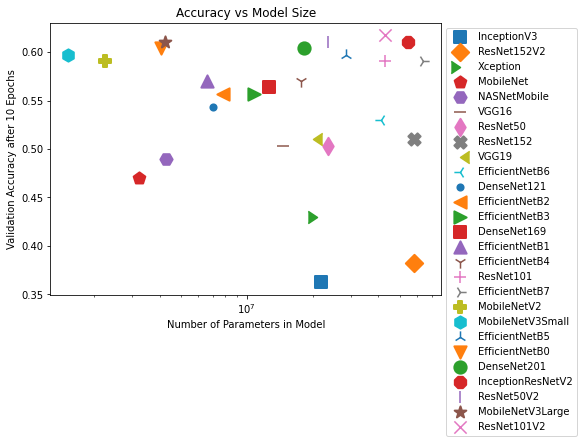

In [27]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 10 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot